In [1]:
import matplotlib.pyplot as plt
from spikeinterface import load_sorting_analyzer
import scipy.io
import numpy as np
from pathlib import Path
import os
import process_func.DIO as DIO
from scipy.signal import find_peaks
from rf_func import find_stim_index

animal_id = 'CnL22'
session_id = '20241113_155342'
ishs = ['0', '1', '2', '3']

dot_time = 0.2 # each stimulus last for 0.2s
trial_dur = 480 # each trial last for 480 s. 5*8 pixels, 60 repeats.

dots_order = scipy.io.loadmat(r'\\10.129.151.108\xieluanlabs\xl_cl\code\rf_recon\dots_order.mat')
dots_order = dots_order['dots_order'][0] - 1 # matlab index starts from 1

black_dots_stimuli = np.ones((len(dots_order), 5, 8))
white_dots_stimuli = np.zeros((len(dots_order), 5, 8))

for i, dot in enumerate(dots_order):
    row = dot // 8
    col = dot % 8
    black_dots_stimuli[i, row, col] = 0
    white_dots_stimuli[i, row, col] = 1


start_time = 97322875 # ephys recording start time stamp
end_time = 127991645
black_start = 97830201 # black dots start time stamp
black_end = 112242128
white_start = 112858628 # white dots start time stamp
white_end = 127270573

black_start = black_start - start_time
white_start = white_start - start_time

rec_folder = rf"D:\cl\rf_reconstruction\head_fixed\{animal_id}_{session_id}.rec"

dio_folders = DIO.get_dio_folders(rec_folder)
dio_folders = sorted(dio_folders, key=lambda x:x.name)

pd_time, pd_state = DIO.concatenate_din_data(dio_folders, 1)

time_diff = np.diff(pd_time)/30000
freq = 1./time_diff / 1000 # kHz

minima_indices, _ = find_peaks(-freq, distance=500, height=-1)
black_start = 97830201 # black dots start time stamp
black_end = 112242128

# get the local minima numbers between black_start and black_end
black_minima_indices = minima_indices[(pd_time[minima_indices] > black_start) & (pd_time[minima_indices] < black_end)]
black_minima = pd_time[black_minima_indices]

print('black minima number: ', len(black_minima_indices))

white_start = 112858625 # white dots start time stamp
white_end = 127270570

# get the local minima numbers between white_start and white_end
white_minima_indices = minima_indices[(pd_time[minima_indices] > white_start) & (pd_time[minima_indices] < white_end)]
white_minima = pd_time[white_minima_indices]
print('white minima number: ', len(white_minima_indices))

c:\Users\Windows\.conda\envs\ms10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


black minima number:  2399
white minima number:  2399


\\10.129.151.108\xieluanlabs\xl_cl\code\process_func\readTrodesExtractedDataFile3.py:64: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)


In [2]:
ish = 1
rec_folder = rf'\\10.129.151.108\xieluanlabs\xl_cl\code\sortout\{animal_id}\{session_id}\{ish}'
sorting_results_folders = []
for root, dirs, files in os.walk(rec_folder):
    for dir_name in dirs:
        if dir_name.startswith('sorting_results_'):  # Check if the folder name matches the pattern
            sorting_results_folders.append(os.path.join(root, dir_name))

In [3]:
sorting_results_folder = sorting_results_folders[0]

sorting_analyzer_folder = Path(sorting_results_folder) / 'sorting_analyzer'
out_fig_folder = Path(sorting_results_folder) / 'STA'
out_fig_folder = Path(out_fig_folder)
if not out_fig_folder.exists():
    out_fig_folder.mkdir(parents=True)


sorting_analyzer = load_sorting_analyzer(sorting_analyzer_folder)
print(sorting_analyzer)
sorting = sorting_analyzer.sorting

unit_ids = sorting.unit_ids
fs = sorting.sampling_frequency

SortingAnalyzer: 32 channels - 24 units - 1 segments - binary_folder - sparse - has recording
Loaded 8 extensions: amplitude_scalings, noise_levels, quality_metrics, random_spikes, spike_amplitudes, templates, template_metrics, waveforms


In [9]:
spikes = sorting.get_unit_spike_train(1) + start_time
white_dot_spikes = spikes[(spikes > white_start) & (spikes < white_end)]
black_dot_spikes = spikes[(spikes > black_start) & (spikes < black_end)]


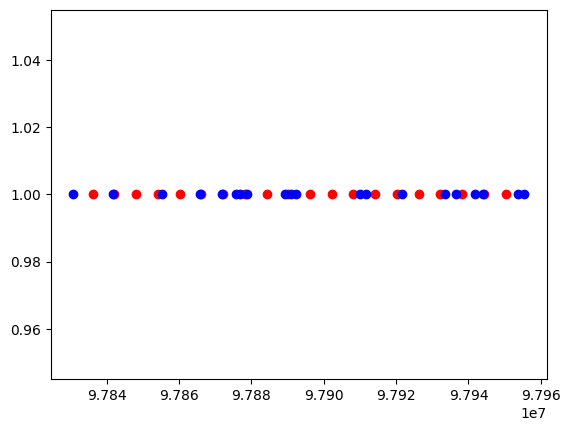

In [10]:
plt.scatter(black_minima[:20], np.ones(20), c='r')
plt.scatter(black_dot_spikes[:20], np.ones(20), c='b')

In [ ]:

for i, unit_id in enumerate(unit_ids):
    spikes = sorting.get_unit_spike_train(unit_id) + start_time  # spike train in sorting is start from 0
    white_dot_spikes = spikes[(spikes > white_start) & (spikes < white_end)]
    black_dot_spikes = spikes[(spikes > black_start) & (spikes < black_end)]

    ST  = []
    ST_white = []
    ST_black = []
    prior_time = 0.2 # s
    for spike in white_dot_spikes:
        i_stimuli = find_stim_index(spike-prior_time*fs, white_minima)
        ST_white.append(white_dots_stimuli[i_stimuli])
        ST.append(white_dots_stimuli[i_stimuli])

    for spikes in black_dot_spikes:
        i_stimuli = find_stim_index(spike-prior_time*fs, black_minima)
        ST.append(black_dots_stimuli[i_stimuli])
        ST_black.append(black_dots_stimuli[i_stimuli])

    # average of ST
    ST = np.array(ST)
    ST_white = np.array(ST_white)
    ST_black = np.array(ST_black)
    STA = np.mean(ST, axis=0)
    STA_white = np.mean(ST_white, axis=0)
    STA_black = np.mean(ST_black, axis=0)